<a href="https://colab.research.google.com/github/SKS200/Tickmark-Recognition/blob/main/Tickmark_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#data path
#trainpath = '/content/drive/MyDrive/PL DATASET/DATASET /empty'
#testpath = '/content/drive/MyDrive/PL DATASET/DATASET /filled'

In [ ]:
!unzip -qq data.zip

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#data path
trainpath = '/content/drive/MyDrive/PL DATASET/DATASET /empty'
testpath = '/content/drive/MyDrive/PL DATASET/DATASET /filled'

In [ ]:
import splitfolders   #or import split_folders
splitfolders.ratio("data", output="output", seed=1337, ratio=(.8, .2), group_prefix=None) # default values


Copying files: 6105 files [00:00, 9583.98 files/s]


In [ ]:
import random
import cv2
import numpy as np

def add_noise(img):
  size = 3
  k = np.zeros((size,size))
  k = k + random.randint(0,50)
  times = random.randrange(2,4,2)
  img = np.reshape(img,(img.shape[0],img.shape[1]))
  for t in range(times):
      col = random.randint(0,img.shape[1]-size-1)
      row = random.randint(0,img.shape[0]-size-1)
      img[row:row+size,0:size] = k
      img[0:size,col:col+size] = k
      col = random.randint(0,img.shape[1]-size-1)
      row = random.randint(0,img.shape[0]-size-1)
      img[row:row+size,-size:] = k
      img[-size:,col:col+size] = k
  return img
    
def preprocess(img):
  x = random.random()
  # print(img.shape)
  if(x<0.25):
    img = cv2.GaussianBlur(img,(3,3),0)

  if(x>=0.25 and x<0.5):
    filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    img=cv2.filter2D(img,-1,filter)
  
  # if(random.random()<0.2):
  #   alpha = random.uniform(1, 1.5)
  #   beta = random.randint(0, 1)
  #   img = np.float32(cv2.convertScaleAbs(img, alpha=alpha, beta=beta))
  # if(random.random()<0.2):
  #   img = add_noise(img)  


  return np.reshape(img,(1,48,48,1))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale =1./255,
        width_shift_range = 0.05,
        height_shift_range = 0.05,
        # zoom_range = [0.8,1],
        preprocessing_function = preprocess)
val_datagen = ImageDataGenerator(
        rescale =1./255)
train_generator = train_datagen.flow_from_directory(
    'output//train',
    target_size = (48, 48),
    color_mode = 'grayscale',
    batch_size = 16,
    class_mode = 'binary')
val_generator= val_datagen.flow_from_directory(
    'output//val',
    target_size = (48, 48),
    color_mode = 'grayscale',
    batch_size = 16,
    class_mode = 'binary')

Found 4884 images belonging to 2 classes.
Found 1221 images belonging to 2 classes.


(16, 48, 48, 1)


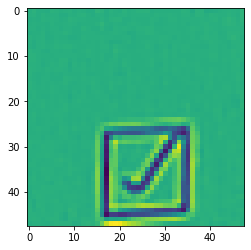

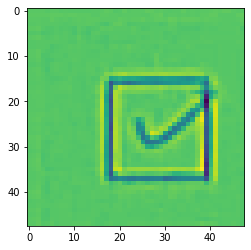

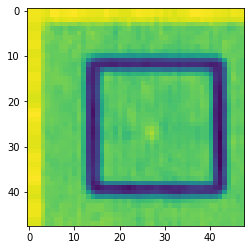

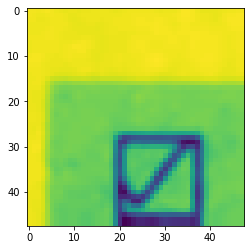

In [ ]:
import matplotlib.pyplot as plt
x_batch, y_batch = train_generator.next()
print(x_batch.shape)
for i in range (0,4):
    image1 = x_batch[i].squeeze( axis=2)
    # print(np.unique(image2))
    plt.imshow(image1)
    plt.show()

In [ ]:
from keras.models import Sequential
from keras import optimizers
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Reshape, LSTM, Input
model = Sequential()

model.add(Input((48,48,1)))

#add the layer below for an accuracy of 89%.(Training time - over 20 hours)
model.add(Convolution2D(32, (3,3), input_shape=(48,48,1),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(32, (3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(64, (3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(128, (3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.2))

model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# model.summary()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam


model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['acc'])
mcp_save = ModelCheckpoint('checkbox_final.h5', save_best_only=True, monitor='val_loss', mode='min')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size
history = model.fit_generator(train_generator,steps_per_epoch=STEP_SIZE_TRAIN,validation_data=val_generator,validation_steps=STEP_SIZE_VALID,epochs=10)

In [ ]:
model.save('eight.h5')